# Answering Business Questions using SQL

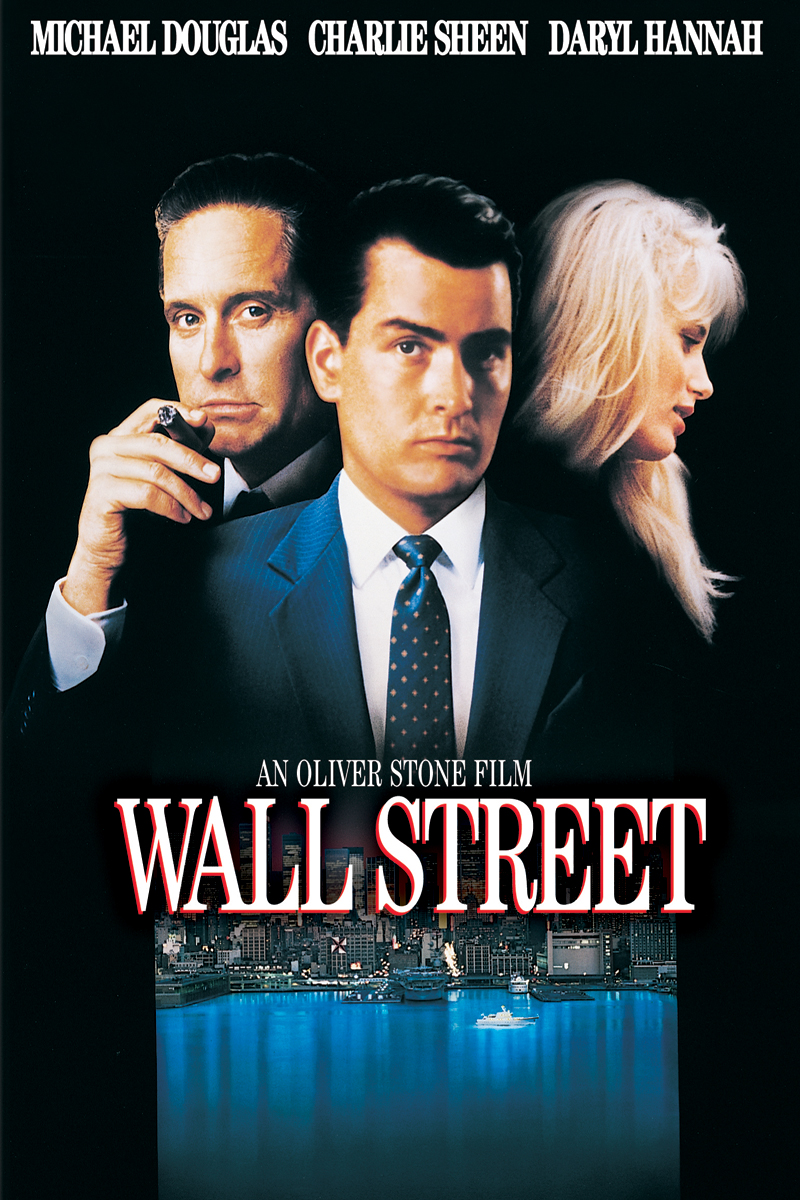

The goal of this work - get answer for business questions using SQL and data from chinok database, you can download it <a href="https://github.com/lerocha/chinook-database" target="_blank">here</a>.
First step - connect to database: 

In [1]:
%%capture
%load_ext sql
%sql sqlite:///data/chinook.db

and explore  structure of database:

In [2]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

 * sqlite:///data/chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


as we see database doesn't contain any views, let begin answer for business questions.
For creating SQL queries we will use this chema.



## Total sales and  sales by employees reports for CEO

Write report about total sales  - this is the most CEO  liked report: 

### Total sales

In [3]:
%%sql
SELECT 
	COUNT(DISTINCT c.customer_id) AS "Customers",
	COUNT(DISTINCT c.country) AS "Counties",
	COUNT(DISTINCT i.invoice_id) AS "Invoices",
	COUNT(il.track_id) AS "Sold Tracks",
	ROUND(SUM(il.quantity * il.unit_price), 2) AS "Total Amount"
FROM 
	customer AS c
INNER JOIN invoice AS i ON 
c.customer_id = i.customer_id 
INNER JOIN invoice_line AS il ON
il.invoice_id = i.invoice_id 

 * sqlite:///data/chinook.db
Done.


Customers,Counties,Invoices,Sold Tracks,Total Amount
59,24,614,4757,4709.43


Second most liked CEO report:

### Sales with dispersion of revenue  by countries

In [4]:
%%sql
WITH sales AS 
	(SELECT
        il.track_id, 
        il.quantity, 
        il.unit_price * il.quantity AS amount, 
        i.billing_country AS country
    FROM 
    	invoice_line AS il
    INNER JOIN invoice AS i ON 
    i.invoice_id = il.invoice_id
    ),
    country AS 
    (SELECT
        s.quantity, 
        s.amount, 
        s.country
    FROM
    	sales AS s
    INNER JOIN track AS t ON 
    s.track_id = t.track_id
    ), 
    country_total AS 
    (SELECT 
     	SUM(quantity) AS track_numbers,
     	ROUND (SUM(amount), 2) AS amount, 
     	country
	FROM
    	country
	GROUP BY  country
	), sales_total AS 
	(SELECT
		SUM(track_numbers) AS total_track,
		SUM(amount) AS total_amount,
		country AS total_country
	FROM 
		country_total
	) 
SELECT 
	ct.country,
	ct.track_numbers AS tracks, 
	ROUND (100 * CAST(ct.track_numbers AS FLOAT)/
	(SELECT
		SUM(track_numbers)
	FROM 
		country_total
	)
	, 3) AS number_percent,
	ct.amount AS amount,
	ROUND (100 * ct.amount/
	(SELECT
		SUM(amount)
	FROM 
		country_total
	)
	, 3) 	AS amount_percent
FROM 
	country_total AS ct 
ORDER BY amount DESC

 * sqlite:///data/chinook.db
Done.


country,tracks,number_percent,amount,amount_percent
USA,1051,22.094,1040.49,22.094
Canada,541,11.373,535.59,11.373
Brazil,432,9.081,427.68,9.081
France,393,8.262,389.07,8.262
Germany,338,7.105,334.62,7.105
Czech Republic,276,5.802,273.24,5.802
United Kingdom,248,5.213,245.52,5.213
Portugal,187,3.931,185.13,3.931
India,185,3.889,183.15,3.889
Ireland,116,2.439,114.84,2.439


Us we see first eight countries - from USA to Portugal (33% from total 24 countries) get over 72% of revenue, this  values for revenue and number of customer near for Parreto rule.

Third most liked CEO report - report of revenue for  each sales Sales Support Agent, the  Staff Sales Performance report created with this query.

## Staff Sales Performance report


In [5]:
%%sql
WITH staff_sales AS 
	(SELECT et.first_name || " " || et.last_name AS staff,
            et.country,
            et.hire_date,
            et.email,
            et.birthdate,
            COUNT(ct.customer_id) AS customers,
            ROUND(SUM(i.total), 2) AS sales
    FROM 
    		employee AS et
    INNER JOIN customer AS ct ON
    et.employee_id = ct.support_rep_id
    INNER JOIN invoice  AS i ON 
    ct.customer_id = i.customer_id                               
    WHERE et.title = "Sales Support Agent"    
    GROUP BY staff
    ORDER BY sales DESC)
SELECT staff,
       customers AS "Invoices",
       ROUND(100 * CAST(customers AS FLOAT)/
       (SELECT 
       		SUM(customers) 
       FROM staff_sales
       )
       , 3) AS customers_percnt,
       sales,
       ROUND(100 * sales/
       (SELECT 
       		SUM(sales) 
       FROM staff_sales
       )
       , 3) AS sales_percent,
       country, 
       email,
       hire_date,
       birthdate
  FROM staff_sales;

 * sqlite:///data/chinook.db
Done.


staff,Invoices,customers_percnt,sales,sales_percent,country,email,hire_date,birthdate
Jane Peacock,212,34.528,1731.51,36.767,Canada,jane@chinookcorp.com,2017-04-01 00:00:00,1973-08-29 00:00:00
Margaret Park,214,34.853,1584.0,33.635,Canada,margaret@chinookcorp.com,2017-05-03 00:00:00,1947-09-19 00:00:00
Steve Johnson,188,30.619,1393.92,29.598,Canada,steve@chinookcorp.com,2017-10-17 00:00:00,1965-03-03 00:00:00


Us we see sales performance all three  Sales Support Agents are little differences and 59 customers payed  614 invoices.

## Report for marketing Department for countries ant theirs musical prefer 

Write query for marketing department for USA and theirs musical prefers with share of numbers tracks and revenue.

In [6]:
%%sql
WITH sales AS 
	(SELECT
        il.track_id, 
        il.quantity, 
        il.unit_price * il.quantity AS amount, 
        i.billing_country AS country
    FROM invoice_line AS il
    INNER JOIN invoice AS i ON 
    i.invoice_id = il.invoice_id
    ),
    country AS 
    (SELECT
        g.name AS category,
        s.quantity, 
        s.amount, 
        s.country
    FROM
     sales AS s
    INNER JOIN track AS t ON 
    s.track_id = t.track_id
    INNER JOIN genre AS g ON 
    g.genre_id = t.genre_id
    ), 
    genre_count AS 
    (SELECT 
     	category,
     	COUNT(category)AS track_number,
     	ROUND (SUM(amount), 2) AS amount, 
     	country
	FROM
    	country
	GROUP BY category, country
	), genre_total AS 
	(SELECT
		SUM(track_number) AS total_track,
		SUM(amount) AS total_amount,
		country AS total_country 
	FROM 
		genre_count
	GROUP BY total_country) 
SELECT 
	gc.category,
	gc.track_number AS tracks, 
	ROUND (100 * CAST(gc.track_number AS FLOAT)/gt.total_track, 3) AS number_percent,
	gc.amount AS amount,
	ROUND (100 * gc.amount/gt.total_amount, 3) 	AS amount_percent,
	gc.country
FROM 
	genre_count AS gc
INNER JOIN genre_total AS gt ON 
gc.country = gt.total_country
WHERE country ='USA'

 * sqlite:///data/chinook.db
Done.


category,tracks,number_percent,amount,amount_percent,country
Alternative,35,3.33,34.65,3.33,USA
Alternative & Punk,130,12.369,128.7,12.369,USA
Blues,36,3.425,35.64,3.425,USA
Classical,4,0.381,3.96,0.381,USA
Easy Listening,13,1.237,12.87,1.237,USA
Electronica/Dance,5,0.476,4.95,0.476,USA
Heavy Metal,3,0.285,2.97,0.285,USA
Hip Hop/Rap,20,1.903,19.8,1.903,USA
Jazz,14,1.332,13.86,1.332,USA
Latin,22,2.093,21.78,2.093,USA


As we see in the most countries hit of sales are Rock music.

## Report about tracks and albums

In [7]:
%%sql
WITH album_track AS 
	(SELECT
		al.album_id,
		COUNT(t.track_id) AS album_tracks
	FROM 
		album AS al
	INNER JOIN track AS t ON
	al.album_id = t.album_id 
	GROUP BY al.album_id) 	
 	, invoice_album_track AS 
 	(SELECT
		i.invoice_id,
		COUNT(il.track_id) AS tracks,
		t.album_id
	FROM
	invoice AS i
	INNER JOIN invoice_line AS il ON
	i.invoice_id  = il.invoice_id 
	INNER JOIN track AS t ON 
	t.track_id = il.track_id
	GROUP BY t.album_id, i.invoice_id)
	, albums_tracks_pvt AS 
	(SELECT 
		COUNT(DISTINCT iat.invoice_id) AS invoices,
		SUM (CASE
		WHEN 
		iat.tracks = atr.album_tracks AND iat.album_id = atr.album_id
		THEN 1
		ELSE 0 
		END) AS albums,
		SUM (CASE
		WHEN 
		iat.tracks = atr.album_tracks AND iat.album_id = atr.album_id
		THEN iat.tracks
		ELSE 0
		END) AS tracks_in_album,
		SUM (CASE
		WHEN 
		iat.tracks <> atr.album_tracks AND iat.album_id = atr.album_id
		THEN iat.tracks
		ELSE 0
		END) AS  single_tracks 
	FROM invoice_album_track AS iat
	INNER JOIN album_track AS atr ON
	atr.album_id = iat.album_id)
SELECT 
	atp.invoices AS "Invoices",
	atp.albums AS "Albums",
	atp.tracks_in_album AS "Tracks in ablums",
	atp.single_tracks AS "Single tracks",
	(atp.single_tracks + atp.tracks_in_album) AS "Total Tracks"
FROM albums_tracks_pvt AS atp;

 * sqlite:///data/chinook.db
Done.


Invoices,Albums,Tracks in ablums,Single tracks,Total Tracks
614,207,1569,3188,4757


## The most selling artist

This query show first 25 selling artist:

In [8]:
%%sql
WITH  selling_track AS 
 	(SELECT
 		il.track_id, 	
 		COUNT (il.track_id) AS track_number
 	FROM
 	invoice_line AS il
 	GROUP BY track_id
 	)
 SELECT
 	ar.name,
 	SUM(st.track_number) AS "Sold Tracks"
 FROM
	selling_track  AS st
INNER JOIN track AS t ON
t.track_id = st.track_id
INNER JOIN album AS al ON
al.album_id  = t.album_id 
INNER JOIN artist AS ar ON 
ar.artist_id = al.artist_id
GROUP BY ar.name
ORDER BY "Sold Tracks" DESC
LIMIT 25;

 * sqlite:///data/chinook.db
Done.


name,Sold Tracks
Queen,192
Jimi Hendrix,187
Nirvana,130
Red Hot Chili Peppers,130
Pearl Jam,129
AC/DC,124
Guns N' Roses,124
Foo Fighters,121
The Rolling Stones,117
Metallica,106


As we see the most popular rock music and their variations from 1960-th to modern time.

## Dispersion media type of selling tracks

This query show dispersion of media type selling tracks:

In [9]:
%%sql
WITH  selling_track AS 
 	(SELECT
 		il.track_id, 	
 		COUNT (il.track_id) AS track_number
 	FROM
 	invoice_line AS il
 	GROUP BY track_id
 	)
 SELECT
 	mt.name,
 	SUM(st.track_number) AS "Sold Media"
 FROM
	media_type  AS mt
INNER JOIN track AS t ON
t.media_type_id  = mt.media_type_id 
INNER JOIN selling_track AS st ON
t.track_id = st.track_id
GROUP BY mt.name
ORDER BY "Sold Media" DESC;

 * sqlite:///data/chinook.db
Done.


name,Sold Media
MPEG audio file,4259
Protected AAC audio file,439
Purchased AAC audio file,35
AAC audio file,21
Protected MPEG-4 video file,3


Us we see the most popular media type of purchased tracks - standard MPEG without protection.

## Ratio total tracks to selling tracks

Define ratio for selling tracks to total numbers of tracks for sale with this query

In [10]:
%%sql
SELECT
	COUNT(DISTINCT t.track_id ) AS total_tracks,
	COUNT(DISTINCT il.track_id) AS sales_track,
	ROUND(100.0 * 
	(SELECT 
		COUNT(DISTINCT il.track_id)
	FROM invoice_line)/
	(SELECT 
	   COUNT(DISTINCT t.track_id)
	 FROM track)
	 , 3) AS "Selling share %"
FROM 
	track AS t 
LEFT JOIN invoice_line AS il ON
t.track_id = il.track_id 

 * sqlite:///data/chinook.db
Done.


total_tracks,sales_track,Selling share %
3503,1806,51.556


## First ten clients

Define first ten clients with maximal amount

In [11]:
%%sql
WITH invoice_line_pvt AS
	(SELECT
		invoice_id,
		SUM(quantity) AS tracks,
		SUM(quantity*unit_price) AS amount
	FROM 
		invoice_line  AS il
	GROUP BY invoice_id
	),
	invoice_pvt AS 
	(SELECT
		i.customer_id,
		COUNT(i.invoice_id) AS invoices,
		SUM(ilp.tracks) AS tracks,
		SUM(ilp.amount) AS amount 
	FROM
		invoice AS i 
	INNER JOIN invoice_line_pvt AS ilp ON
	ilp.invoice_id = i.invoice_id 
	GROUP BY i.customer_id)
SELECT 
	c.first_name || " " || c.last_name AS "Customer",
	ip.invoices AS "Invoices",
	ip.tracks AS "Tracks",
	ROUND(ip.amount, 2) AS "Amount",
	c.country AS "Country"
FROM 
	customer AS c
INNER JOIN invoice_pvt AS ip ON 
ip.customer_id = c.customer_id 
ORDER BY "Amount" DESC
LIMIT 10

 * sqlite:///data/chinook.db
Done.


Customer,Invoices,Tracks,Amount,Country
František Wichterlová,18,146,144.54,Czech Republic
Helena Holý,12,130,128.7,Czech Republic
Hugh O'Reilly,13,116,114.84,Ireland
Manoj Pareek,13,113,111.87,India
Luís Gonçalves,13,110,108.9,Brazil
Fernanda Ramos,15,108,106.92,Brazil
João Fernandes,13,104,102.96,Portugal
François Tremblay,9,101,99.99,Canada
Wyatt Girard,11,101,99.99,France
Jack Smith,12,99,98.01,USA


## Conclusion
In this works we provide for business and marketing next information:

* Consolidated and detailed  information about sales revenue and theirs dispersion by countries for decision making by management of company.
* Detailed information for marketing department showing musical prefers by country, what prefer customer - albums or tracks, customer prefer type of track's media, ratio sold  tracks to total offering tracks, define key customer.  

Created on Mar 31, 2021

@author: Vadim Maklakov, used some ideas from public Internet resources.

© 3-clause BSD License

Software environment: Debian 10.9, Python 3.8.7

required next preinstalled python modules: ipython-sql.